In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import *
import random
import numpy as np
import pickle

import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from matplotlib.cm import get_cmap

from model import Encoder,WeightSumDecoder
from data import get_feature,standardize_matrix,get_zt_ts
from utils import mins_cross_entropy,shuffle_rows,visualize_weighted_graph

In [2]:
s = 2050
torch.manual_seed(s)
np.random.seed(s)
random.seed(s)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Load test dataset

In [3]:
with open('./data/test_adjs.pkl','rb') as f:
    test_adjs=pickle.load(f)
    
with open('./data/test_feas.pkl','rb') as f:
    test_feas=pickle.load(f)
    
with open('./data/test_names.pkl','rb') as f:
    test_names=pickle.load(f)
    
with open('./data/test_zts.pkl','rb') as f:
    test_zts=pickle.load(f)

In [4]:
# Definition of Encoder
class Encoder(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, n_layers):
        super(Encoder,self).__init__()
        self.convs = torch.nn.ModuleList()
        self.in_proj = torch.nn.Linear(input_dim, hidden_dim)
        nn_seq = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        for _ in range(n_layers):
            self.convs.append(GINConv(nn_seq))
        self.out_proj = torch.nn.Linear((n_layers+1)*hidden_dim+input_dim, output_dim)
    def forward(self,x0,edge_index):
        x = self.in_proj(x0)
        hidden_states = [x0,x]
        for layer in self.convs:
            x = layer(x,edge_index)
            hidden_states.append(x)
        x = torch.cat(hidden_states, dim=1)
        x = self.out_proj(x)
        x = F.softmax(x,dim=-1)
        return x

In [5]:
macro_node = 50
ts = np.logspace(-2,1.5,15,base=10).tolist()
encoder = Encoder(input_dim =5, hidden_dim = 64, output_dim = macro_node, n_layers = 1).to(device)
decoder = WeightSumDecoder(macro_node)

In [6]:
encoder = torch.load('./pre_trained.pth')

In [7]:
curious_id=95
eps=1e-7

X = test_feas[curious_id].float().to(device)

# -mean/std
f_mean = torch.mean(X,dim=0)
f_std = torch.std(X,dim=0)+eps
X = (X-f_mean) / f_std


edge_index = test_adjs[curious_id]
adj = torch_geometric.utils.to_dense_adj(edge_index)[0]
y = test_zts[curious_id].real
# Partition function evaluation
group = encoder(X,edge_index)
new_p = decoder(group,adj.float())
yhat = get_zt_ts(new_p,ts).real

## Visualization of Original Network

In [8]:
g = nx.from_numpy_array(adj.cpu().numpy())

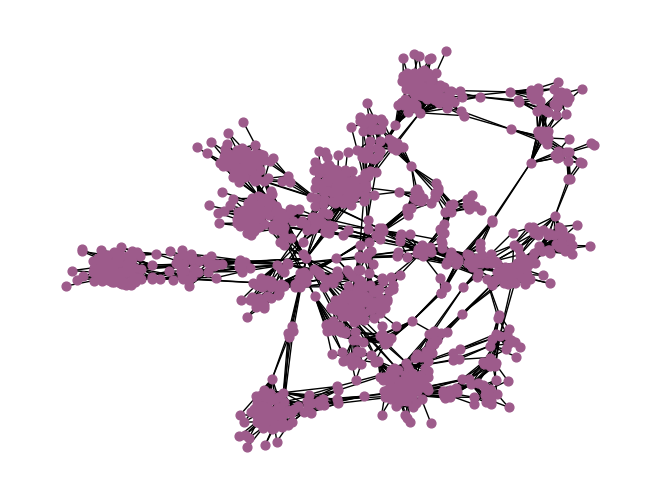

In [9]:
nx.draw(g,node_size=40,node_color='#9d5b8b')

## Visualization of Compressed Network

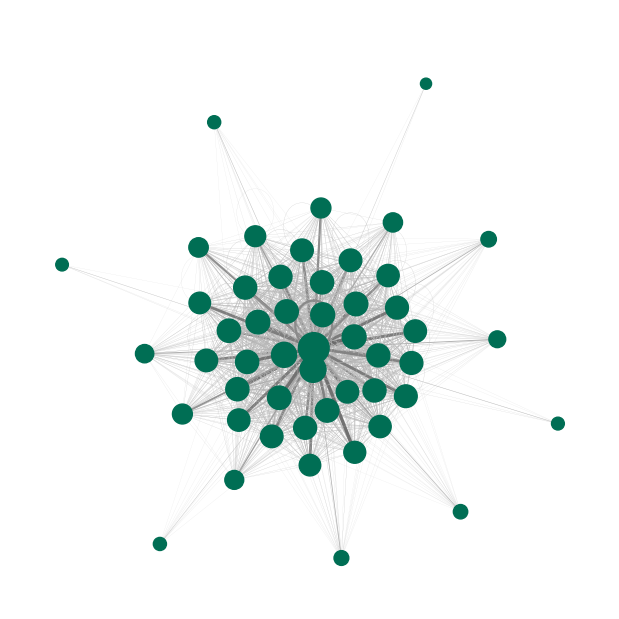

In [10]:
def visualize_weighted_graph(adj_matrix):
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix)

    # Get weights for each edge
    # weights = np.array([data['weight'] for _, _, data in G.edges(data=True)])*1
    weights = []
    for _, _, data in G.edges(data=True):
        # print(data['weight'])
        if data['weight'] < 0.02:
            weights.append(0)
        else:
            weights.append(data['weight'])
    weights = np.array(weights)
    # 使用colormap将数值映射到颜色
    cmap = get_cmap('Greys')  # 可以换成其他colormap，如 'plasma', 'coolwarm'
    
    norm = plt.Normalize(vmin=min(weights)-1, vmax=max(weights)+1.)
    edge_colors = [cmap(norm(w)) for w in weights]
    nsz = np.log(np.sum(adj_matrix,axis=0)+1)*150

    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G,seed=2053)  
    nx.draw(G,pos, with_labels=False, width=weights*3,node_color='#006e54', node_size=nsz,edge_color=edge_colors, edge_cmap=plt.cm.Greys)
    plt.show()
visualize_weighted_graph(new_p.detach().cpu().numpy())

## Comparesion of Partition functions

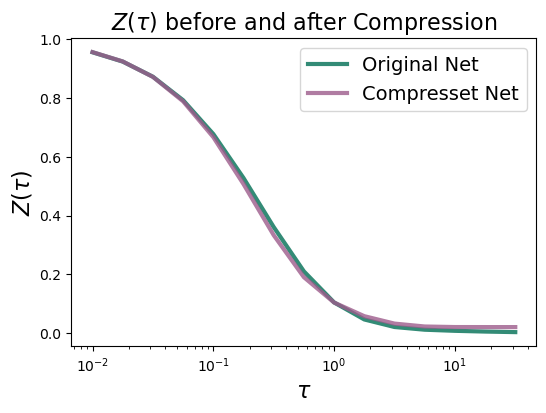

In [11]:
plt.figure(figsize=(6,4))
plt.plot(ts,y.cpu(),color='#006e54',linewidth=3, label='Original Net',alpha=0.8)
plt.plot(ts,yhat.detach().cpu(),color='#9d5b8b',linewidth=3, label='Compresset Net',alpha=0.8)
plt.title(r'$Z(\tau)$ before and after Compression',fontsize=16)
plt.xlabel(r'$\tau$',fontsize=16)
plt.ylabel(r'$Z(\tau)$',fontsize=16)
plt.legend(fontsize=14)
plt.xscale('log')